In [2]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sys.path.insert(0, '../')
from species_classification_scripts.individual_stands_classification import Generator

In [ ]:
class_0=['conifer']
class_1=['decidious']
folders = ['0', '1']
num_channels = 9
batch_size = 32

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)
generator.wv = True
generator.IMG_ROW = 128
generator.IMG_COL = 128
generator.sup_materials = True
generator.sup_name = '_pred.tif'
generator.sup_normalization = 40.
generator.channels_name = ['_channel_0', '_channel_1', '_channel_2', '_channel_3',
                          '_channel_4', '_channel_5', '_channel_6', '_channel_7']
weights_list = [ 1., 1.]
loss =  generator.weighted_categorical_crossentropy(weights_list)  

generator.load_dataset(folders)
generator.set_normalize_channel()

In [27]:
def split_img(img, IMG_ROW, IMG_COL, overlap):
    height_ind = 0
    height = 0
    imgarr = []
    while height < img.shape[0]:
        width_ind = 0
        width = 0
        while width < img.shape[1]:
            tmp = np.zeros((IMG_ROW, IMG_COL, img.shape[2]))
            tmp1 = img[height:min(height+IMG_ROW, img.shape[0]), 
                               width:min(width + IMG_COL, img.shape[1])]
            tmp[:tmp1.shape[0],:tmp1.shape[1],:] = tmp1

            #padding
            if tmp.shape[0] != tmp1.shape[0]:
                tmp[tmp1.shape[0]:tmp1.shape[0]+min(tmp.shape[0] - tmp1.shape[0], tmp1.shape[0]),:tmp1.shape[1]] = \
                    np.flip(tmp1, 0)[:min(tmp.shape[0] - tmp1.shape[0], tmp1.shape[0]),:]
            if tmp.shape[1] != tmp1.shape[1]:   
                tmp[:tmp1.shape[0],tmp1.shape[1]:tmp1.shape[1]+min(tmp.shape[1] - tmp1.shape[1], tmp1.shape[1])] = \
                    np.flip(tmp1, 1)[:,:min(tmp.shape[1] - tmp1.shape[1], tmp1.shape[1])]

            imgarr.append(tmp)

            width_ind += 1
            width += IMG_COL - 2*overlap

        height += IMG_ROW - 2*overlap
        height_ind += 1
    return np.asarray(imgarr), height_ind, width_ind

def reconstruct_pred(pred, size_x, size_y, IMG_ROW, IMG_COL, overlap, height_ind, width_ind):
    recon = np.empty((size_x, size_y, pred.shape[-1]), pred.dtype)
    final_patch = IMG_ROW - overlap 
    for i in range(height_ind):
        for j in range(width_ind):
            recon[(i!=0) *(final_patch + (i-1)*(IMG_ROW - 2*overlap)): min(final_patch + i*(IMG_ROW - 2*overlap), size_x),
                 (j!=0) *(final_patch + (j-1)*(IMG_COL - 2*overlap)): min(final_patch + j*(IMG_COL - 2*overlap), size_y),:] = \
            pred[i*width_ind + j][overlap*(i!=0):-max(overlap, final_patch - (size_x - (i!=0) *(final_patch + (i-1)*(IMG_ROW - 2*overlap)))), 
                       overlap*(j!=0):-max(overlap, final_patch - (size_y - (j!=0) *(final_patch + (j-1)*(IMG_COL - 2*overlap)))),:]
    return recon


def pred_img(model, img_path, num_classes=2): 
    #--------------------------------------------------------------
    # pred_img function allows to make prediction for an image of 
    # any size (not the power of 2)
    #--------------------------------------------------------------

    IMG_ROW = IMG_COL = 512
    overlap = 128

    img,mask = get_img_mask_array(img_path)

    size_x, size_y, _ = img.shape

    imgarr, height_ind, width_ind = split_img(img, IMG_ROW, IMG_COL, overlap)

    pred = np.asarray([model.predict(np.asarray([img_patch]))[0] for img_patch in imgarr])
    recon = reconstruct_pred(pred, size_x, size_y, IMG_ROW, IMG_COL, overlap, height_ind, width_ind)

    return recon, mask

In [19]:
def get_img_mask_array(img_path, sup_normalization=40.):
    num_channels=9
    class_0=['conifer']
    class_1=['decidious'] 
    num_classes=2
    channels_name = ['_channel_0', '_channel_1', '_channel_2', '_channel_3',
                          '_channel_4', '_channel_5', '_channel_6', '_channel_7']
    sup_name = '_pred.tif'
    with rasterio.open(img_path + '_channel_0.tif') as src:
        IMG_ROW = src.width
        IMG_COL = src.height

    img = np.ones((IMG_COL, IMG_ROW, num_channels), dtype=np.float)
    for i, ch in enumerate(channels_name):
        channel_name = img_path + ch + '.tif'
        with rasterio.open(channel_name) as src:
            img[:,:,i] = src.read(1)
    width=3
    mean = normalize_channel[img_path][0]
    std = normalize_channel[img_path][1]
    img_max = normalize_channel[img_path][2]
    img_min = normalize_channel[img_path][3]
    m = max(0, mean - width*std)
    M = min(img_max, mean + width*std)

    img = ((img - m)/(M-m)).clip(0., 1.)
    
    img = img.clip(0, 1)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # suplementary materials
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    channel_name = img_path + sup_name
    with rasterio.open(channel_name) as src:
        img[:,:,-1] = src.read(1).astype(np.float)
    img[:,:,-1] = (img[:,:,-1] / sup_normalization).clip(0., 1.)
    
    mask_0 = np.zeros((1, IMG_COL, IMG_ROW))
    for cl_name in class_0:
        #if '{}.tif'.format(cl_name) in os.listdir(imgpath):
        with rasterio.open(img_path+ '_{}.tif'.format(cl_name)) as src:
            mask_0 += src.read(1).astype(np.int)

    mask_1 = np.zeros((1, IMG_COL, IMG_ROW))
    for cl_name in class_1:
        #if '{}.tif'.format(cl_name) in os.listdir(imgpath):
        with rasterio.open(img_path + '_{}.tif'.format(cl_name)) as src:
            mask_1 += src.read(1).astype(np.int)

    mask = np.ones((IMG_COL, IMG_ROW, num_classes)) 
    mask[:,:,0] = mask_0  
    mask[:,:,1] = mask_1 

    return np.asarray(img), np.asarray(mask)

In [7]:
normalize_channel = {}
for ind in ['1_1', '2_2', '4_2', '6_3']:
    path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/val/'+ ind
    normalize_channel[path] = {}
    tmp = []
    for ch in range(8):
        with rasterio.open(path + '_channel_' + str(ch) + '.tif') as src:
            tmp += [src.read(1)]
    tmp = np.asarray(tmp)
    normalize_channel[path] = []
    normalize_channel[path] += [np.mean(tmp[tmp>0])]
    normalize_channel[path] += [np.std(tmp[tmp>0])]
    normalize_channel[path] += [tmp.max()]
    normalize_channel[path] += [tmp[tmp>0].min()] #tmp.min

In [20]:
for ind in ['1_1', '2_2', '4_2', '6_3']:
    img_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/val/'+ ind
    img, mask = get_img_mask_array(img_path)
    break

In [26]:
from keras.backend import categorical_crossentropy

model = Unet(backbone_name='resnet34', input_shape=(None, None, 9), classes=2,
                  encoder_weights=None, activation='softmax')
opt = RMSprop(lr=0.001)
metrics=[categorical_crossentropy]
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=metrics)

model_name = 'multispectral_lidar'
save_dir = '/home/user/data/example/data/Forestry_inventory/usgs_species_classification/'

model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [28]:
recon, mask = pred_img(model, img_path)

In [34]:
mask.shape

(1272, 2105, 2)

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7f0db9f79e48>)

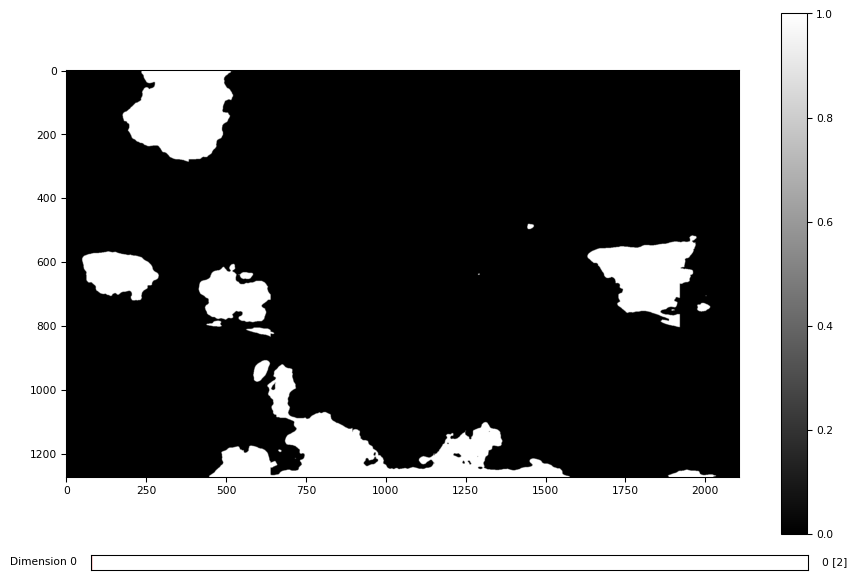

In [32]:
tiff.imshow(recon>0.5)

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7f0db9e5b358>)

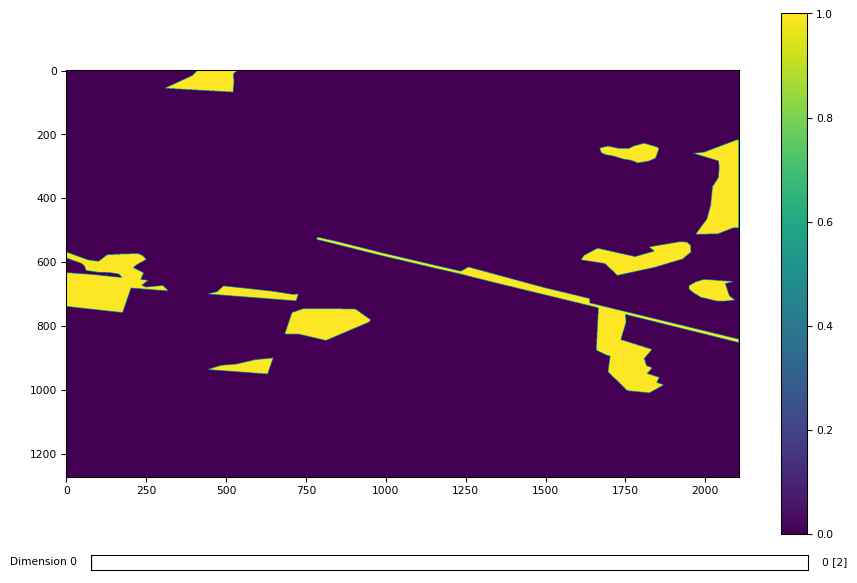

In [33]:
tiff.imshow(mask)

In [36]:
recon.shape

(1272, 2105, 2)

In [42]:
pred = np.array((recon.shape))
pred.shape

(3,)

In [43]:
pred = recon#np.array((recon.shape))
pred[:,:,0] = recon[:,:,0]>0.5
pred[:,:,1] = recon[:,:,1]>0.5
(pred).shape

(1272, 2105, 2)

In [35]:
from height_model_scripts.metrics import F1_metric

In [46]:
F1_metric(class_names=['con', 'dec'], mask=np.asarray([mask]), num_cl=2, pred=np.asarray([pred]))

con : precision  0.174  recall  0.283  f1  0.215
 
dec : precision  0.948  recall  0.907  f1  0.927
 


array([0.21542901, 0.92680808])

In [47]:
for ind in ['1_1', '2_2', '4_2', '6_3']:
    img_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/val/'+ ind
    img, mask = get_img_mask_array(img_path)
    
    recon, mask = pred_img(model, img_path)
    
    pred = recon#np.array((recon.shape))
    pred[:,:,0] = recon[:,:,0]>0.5
    pred[:,:,1] = recon[:,:,1]>0.5
    F1_metric(class_names=['con', 'dec'], mask=np.asarray([mask]), num_cl=2, pred=np.asarray([pred]))
    
    

con : precision  0.174  recall  0.283  f1  0.215
 
dec : precision  0.948  recall  0.907  f1  0.927
 
con : precision  0.808  recall  0.971  f1  0.882
 
dec : precision  0.865  recall  0.442  f1  0.585
 
con : precision  0.796  recall  0.984  f1  0.88
 
dec : precision  0.891  recall  0.345  f1  0.498
 
con : precision  0.714  recall  0.987  f1  0.829
 
dec : precision  0.948  recall  0.381  f1  0.544
 
